# Australian Beer Production TSA
- **Note:** This notebook was created to test concepts around time series analysis as they were being taught during a Master Class at NOVA IMS. The code below was not provided by the professor/University, but rather written to exemplify TSA techniques.

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports and ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm

%matplotlib inline

/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
url = "https://raw.githubusercontent.com/jamesrobertlloyd/gp-structure-search/master/data/raw/TSDL/monthly-beer-production-in-austr.csv"
df = pd.read_csv(url)
df.columns = ['Month','Australian_monthly_beer_prod']
df.drop(476, axis=0, inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

Australian_monthly_beer_prod
Month                                   
1956-01-01                          93.2
1956-02-01                          96.0
1956-03-01                          95.2
1956-04-01                          77.1
1956-05-01                          70.9

In [3]:
df.describe().T

count        mean        std   min    25%  \
Australian_monthly_beer_prod  476.0  136.395378  33.738725  64.8  112.9   

                                 50%      75%    max  
Australian_monthly_beer_prod  139.15  158.825  217.8

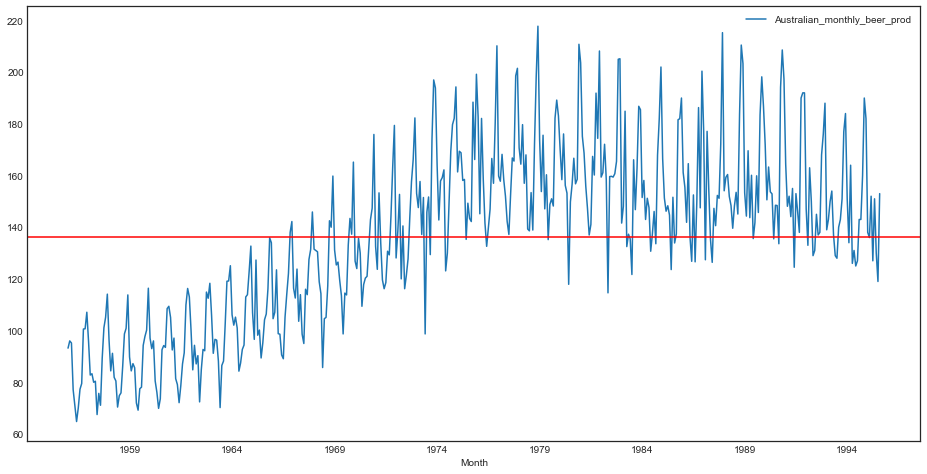

In [4]:
df.plot(figsize=(16,8))
plt.axhline(y=df.mean()[0], color='r', linestyle='-');

# Rolling - Moving Average & EWMA

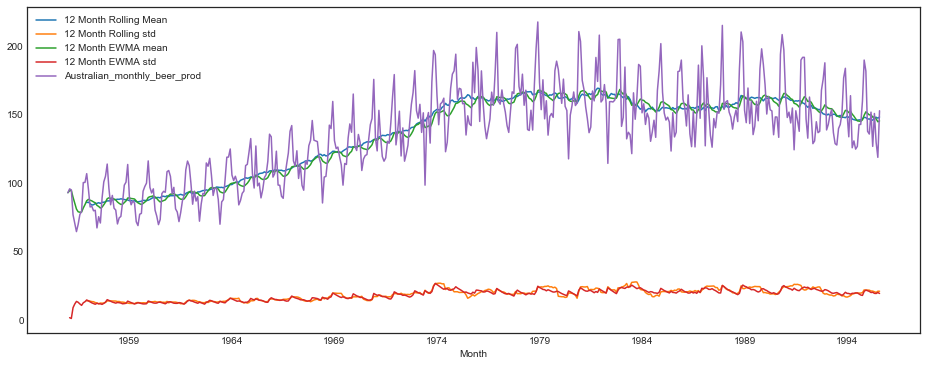

In [5]:
df['Australian_monthly_beer_prod'].rolling(12).mean().plot(label='12 Month Rolling Mean', figsize=(16,6))
df['Australian_monthly_beer_prod'].rolling(12).std().plot(label='12 Month Rolling std')
df['Australian_monthly_beer_prod'].ewm(12).mean().plot(label='12 Month EWMA mean')
df['Australian_monthly_beer_prod'].ewm(12).std().plot(label='12 Month EWMA std')
df['Australian_monthly_beer_prod'].plot()
plt.legend();

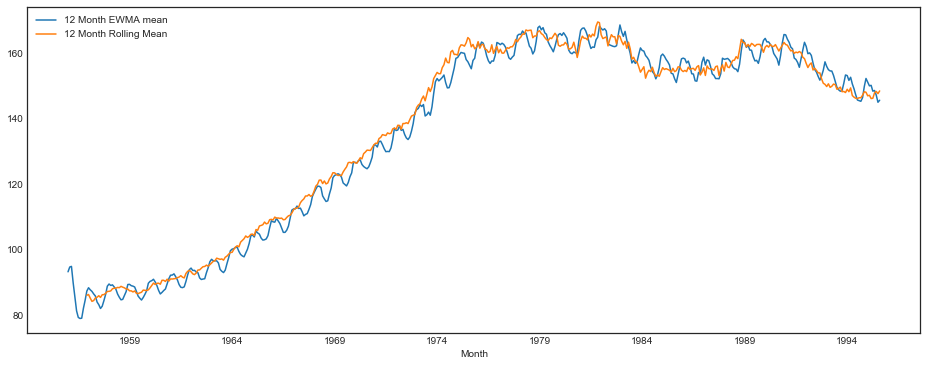

In [6]:
df['Australian_monthly_beer_prod'].ewm(12).mean().plot(label='12 Month EWMA mean', figsize=(16,6))
df['Australian_monthly_beer_prod'].rolling(12).mean().plot(label='12 Month Rolling Mean')
#df['Australian_monthly_beer_prod'].ewm(12).std().plot(label='12 Month EWMA std')
#df['Australian_monthly_beer_prod'].plot()
plt.legend();

# Decomposition

<Figure size 432x288 with 0 Axes>

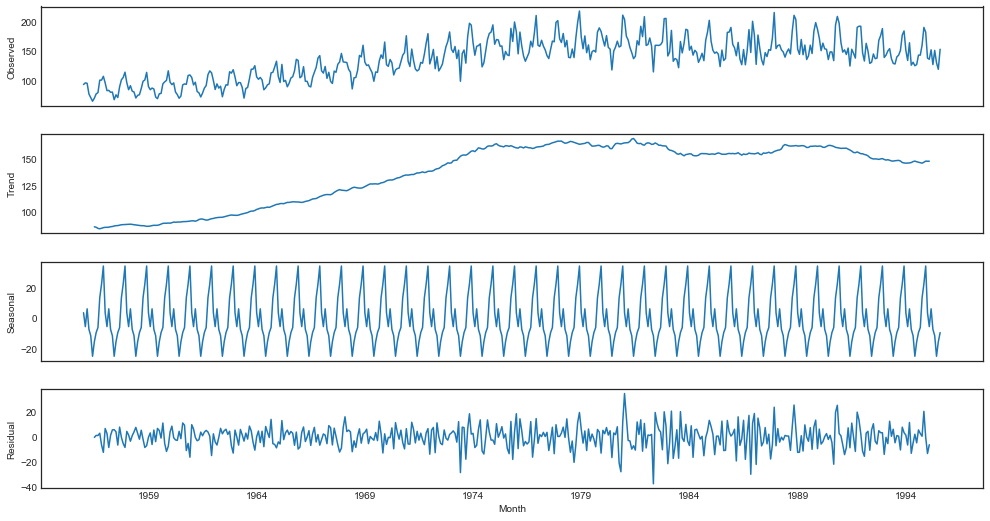

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Australian_monthly_beer_prod'],model='additive', freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8);

## De-trending the data

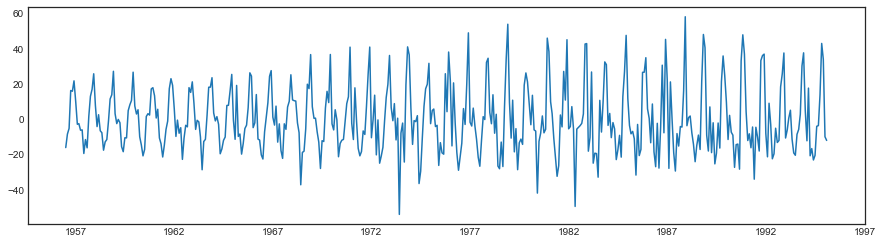

In [8]:
plt.figure(figsize=(15,4))
plt.plot(df['Australian_monthly_beer_prod'] - decomposition.trend)

## De-trended and de-seasonalized data

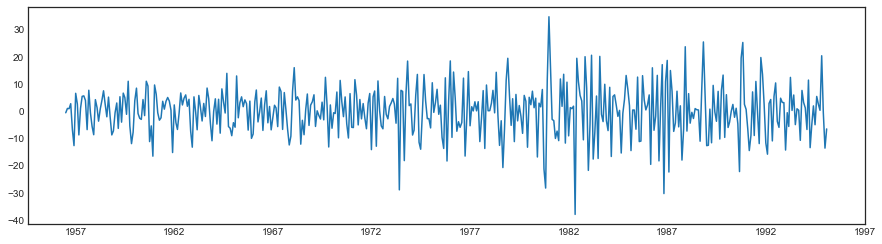

In [9]:
plt.figure(figsize=(15,4))
plt.plot(df['Australian_monthly_beer_prod'] - decomposition.trend - decomposition.seasonal);

In [10]:
(df['Australian_monthly_beer_prod'] - decomposition.trend - decomposition.seasonal - decomposition.resid).unique()

array([nan,  0.])

That means if our data is composed by seasonality, trend and residuals. Without it, it's a constant zero.

## Residuals

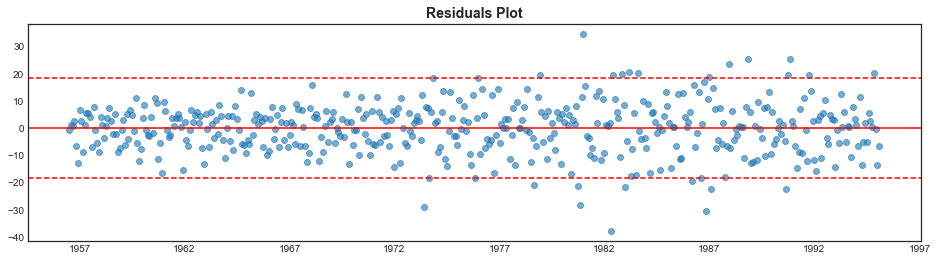

In [11]:
plt.figure(figsize=(16,4))
plt.scatter(df.index,decomposition.resid, alpha=0.6)
plt.axhline(decomposition.resid.mean(), color='r', linestyle='-') #mean
plt.axhline(decomposition.resid.std()*2, color='r', linestyle='--') #std upper
plt.axhline(-decomposition.resid.std()*2, color='r', linestyle='--') #std lower
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.show()

In [12]:
decomposition.resid.std()

9.155483519377531

# Testing for Stationarity

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('|||Augmented Dickey-Fuller Test|||')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis: reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis: time series has a unit root, indicating it is non-stationary ")

In [14]:
adf_check(df['Australian_monthly_beer_prod'])

|||Augmented Dickey-Fuller Test|||
ADF Test Statistic : -2.2826614187875793
p-value : 0.17762099829132416
#Lags Used : 17
Number of Observations Used : 458
Weak evidence against null hypothesis: time series has a unit root, indicating it is non-stationary 


# Differentiating

## First Difference

In [15]:
df['First_Diff'] = df['Australian_monthly_beer_prod'] - df['Australian_monthly_beer_prod'].shift(1)

adf_check(df['First_Diff'].dropna()) #this was already enough, as the data became stationary

|||Augmented Dickey-Fuller Test|||
ADF Test Statistic : -4.980663743064925
p-value : 2.423411785994607e-05
#Lags Used : 18
Number of Observations Used : 456
Strong evidence against the null hypothesis: reject the null hypothesis. Data has no unit root and is stationary


In [16]:
df['Second_Diff'] = df['Australian_monthly_beer_prod'] - df['Australian_monthly_beer_prod'].shift(2)

adf_check(df['Second_Diff'].dropna())

|||Augmented Dickey-Fuller Test|||
ADF Test Statistic : -4.051222497916612
p-value : 0.0011648119802485123
#Lags Used : 18
Number of Observations Used : 455
Strong evidence against the null hypothesis: reject the null hypothesis. Data has no unit root and is stationary


In [17]:
df['First_Diff'].mean()

0.12589473684210528

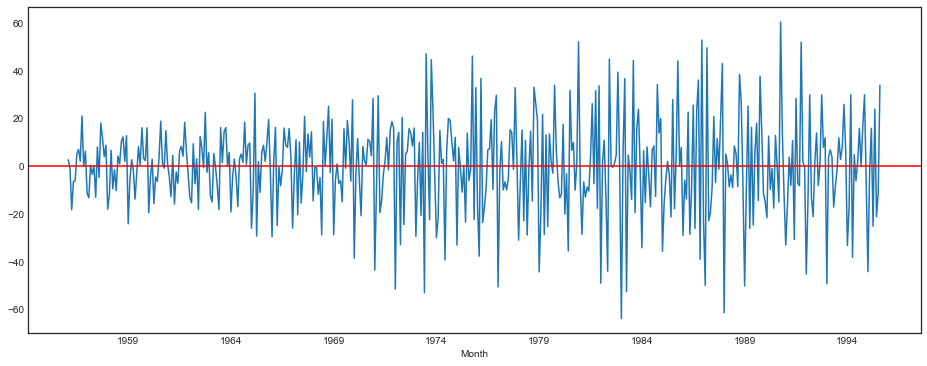

In [18]:
df['First_Diff'].plot(figsize=(16,6))
plt.axhline(y=df['First_Diff'].mean(), color='r', linestyle='-');

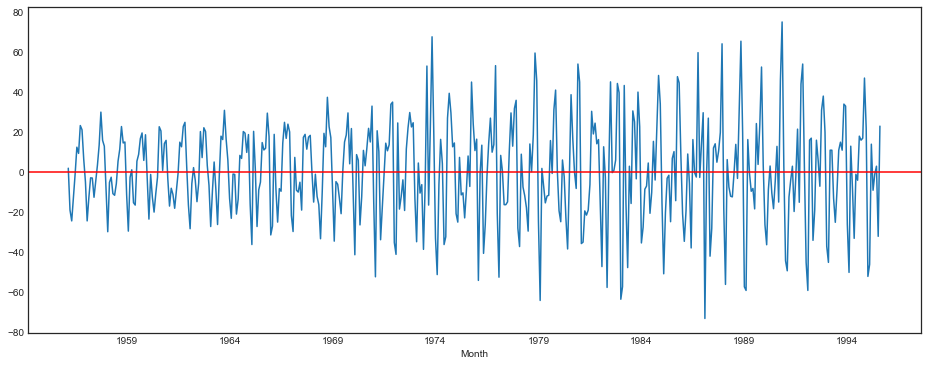

In [19]:
df['Second_Diff'].plot(figsize=(16,6))
plt.axhline(y=df['Second_Diff'].mean(), color='r', linestyle='-');

## Seasonal Difference

In [20]:
df['Seasonal_Diff'] = df['Australian_monthly_beer_prod'] - df['Australian_monthly_beer_prod'].shift(12)

adf_check(df['Seasonal_Diff'].dropna())

|||Augmented Dickey-Fuller Test|||
ADF Test Statistic : -2.8967624777519667
p-value : 0.04572577462360121
#Lags Used : 17
Number of Observations Used : 446
Strong evidence against the null hypothesis: reject the null hypothesis. Data has no unit root and is stationary


In [21]:
df['Seasonal_Diff'].mean()

1.6131465517241381

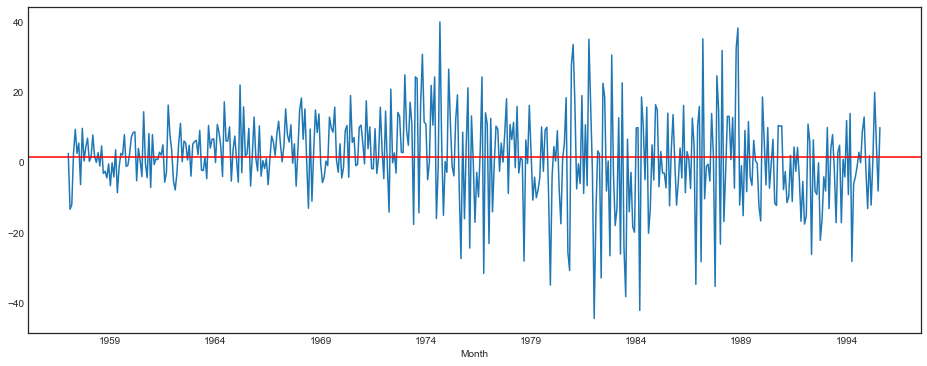

In [22]:
df['Seasonal_Diff'].plot(figsize=(16,6))
plt.axhline(y=df['Seasonal_Diff'].mean(), color='r', linestyle='-');

# Autocorrelation

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

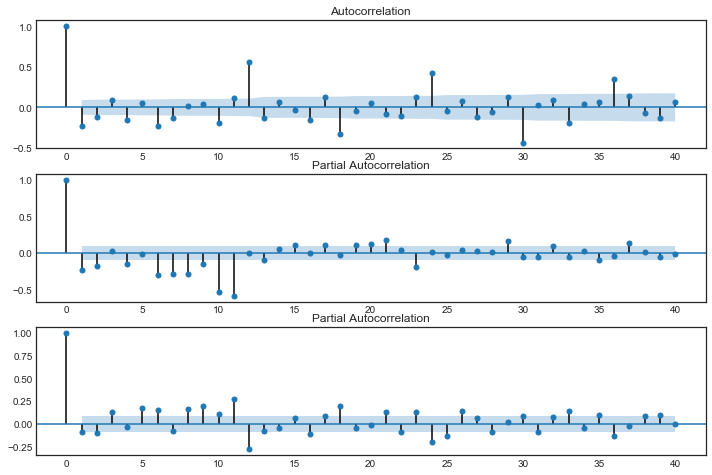

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(df['First_Diff'].iloc[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_pacf(df['First_Diff'].iloc[1:], lags=40, ax=ax2)
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal_Diff'].iloc[13:], lags=40, ax=ax3)

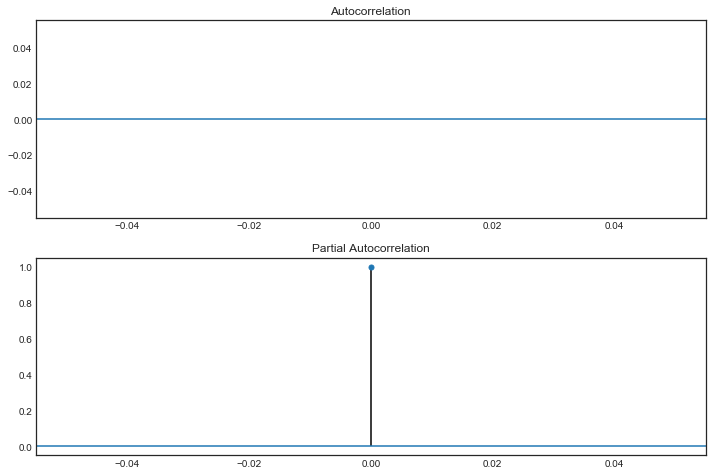

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Second_Diff'].iloc[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Second_Diff'].iloc[1:], lags=40, ax=ax2)

## Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

<font color='red'>
- According to the professor, for both a sharp drop and a gradual decline a AR-k should be used. If there's 1 line only a 1st-order-MA should be used, 2 lines only a 2nd-order-MA... I took a picture of 6 plots on the whiteboard on April 3rd.
</font>

**IMP**: whatever is below the bands (in the blue region) is considered 0 (zero)!!

- class notes from April 3rd: **PACF**: in a linear model, if the variables (xk and y) are standardized, the model measures also the association of each beta with y, as the other betas are fixed (because they are standardized). This way, we are analyzing the association of y (the axis y) with each separate lag (as other lags are fixed, so their influences are curtailed).
- Identification of an AR is best done (in general) with a PACF.
- on the photo: the "ARMA(2,2)" means AR_component=2 e MA_component=2.


## Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

# Seasonal ARIMA Model

## p,d,q parameters

* p: The number of lag observations included in the model. **# autoregressive order**
* d: The number of times that the raw observations are differenced, also called the degree of differencing. **#differences**
* q: The size of the moving average window, also called the order of moving average. **#order of MA model**

In [66]:
model = sm.tsa.statespace.SARIMAX(df['Australian_monthly_beer_prod'],order=(12,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

#chose 12 in the autoregressive order because of the ACF: it presents a spike on the 12th lag.

#we normally use the ACF to determine p and PACF to determine q. If the PACF shows a decreasing trend,
#we pick q based on the lag that goes under the blue band limit. (see picture taken on 19:59 10-04-2018)

                                  Statespace Model Results                                 
Dep. Variable:        Australian_monthly_beer_prod   No. Observations:                  476
Model:             SARIMAX(12, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1684.492
Date:                             Tue, 10 Apr 2018   AIC                           3398.984
Time:                                     20:01:01   BIC                           3461.465
Sample:                                 01-01-1956   HQIC                          3423.553
                                      - 08-01-1995                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0338      0.043    -24.288      0.000      -1.117      -0.950
ar.L2         -1.0914      

In [43]:
model = sm.tsa.statespace.SARIMAX(df['Australian_monthly_beer_prod'],order=(1,0,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:       Australian_monthly_beer_prod   No. Observations:                  476
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1803.067
Date:                            Tue, 10 Apr 2018   AIC                           3616.133
Time:                                    19:22:01   BIC                           3636.960
Sample:                                01-01-1956   HQIC                          3624.323
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9158      0.019    -48.152      0.000      -0.953      -0.879
ma.L1          0.9998      0.155   

In [53]:
model = sm.tsa.statespace.SARIMAX(df['Australian_monthly_beer_prod'],order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:       Australian_monthly_beer_prod   No. Observations:                  476
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1729.145
Date:                            Tue, 10 Apr 2018   AIC                           3468.290
Time:                                    19:23:44   BIC                           3489.117
Sample:                                01-01-1956   HQIC                          3476.479
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1619      0.039     -4.109      0.000      -0.239      -0.085
ma.L1         -0.8865      0.020   

<font color='red'>**Class notes: 10-04-2018**</font>
- slide 32: we want the p-values to be above the blue line (plot 3)
- slide 37: presents AIC, BIC, etc greater than the previous model (a few slides back _ same structure)
- slide 40: all p-values are below the blue line. This means that this is not a white noise process.
- slide 47: Ljung-Box statistic - implement it bellow on section 7.2

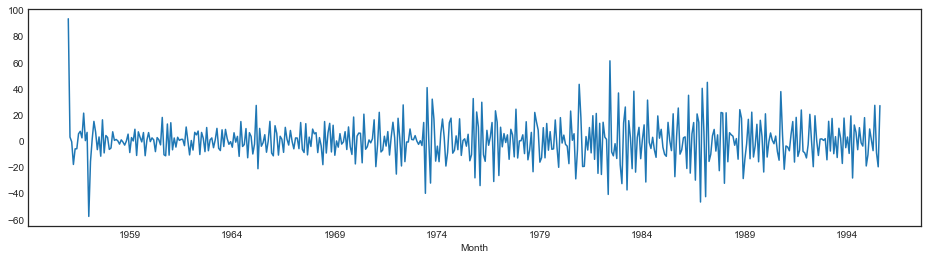

In [27]:
results.resid.plot(figsize=(16,4));

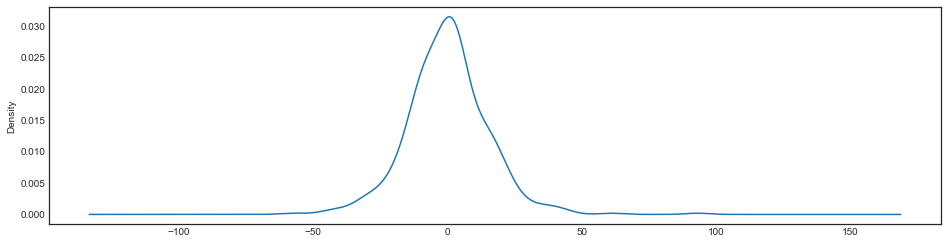

In [28]:
results.resid.plot(kind='kde', figsize=(16,4));

## Ljung-Box Statistic (class material 10-04-2018. slide 47)

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox

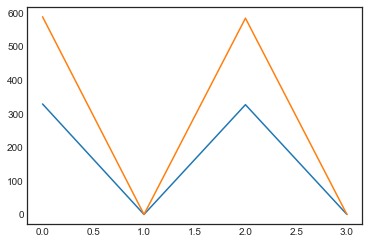

In [63]:
plt.plot(acorr_ljungbox(df['Australian_monthly_beer_prod'], lags=2, boxpierce=True))

In [64]:
acorr_ljungbox(df['Australian_monthly_beer_prod'], lags=2, boxpierce=False)

(array([328.95734463, 588.80893613]),
 array([1.62136264e-073, 1.38600268e-128]))

# Prediction of Future Values

<font color='red'>class notes 10-04-2018</font>
**- Forecasting:** slide 60. 
- slide 65: 'psi-weight': we remove the mean to have a centered timeseries (3rd bullet). Slide 66: simplifies the equation. 67: continues to simplify it.

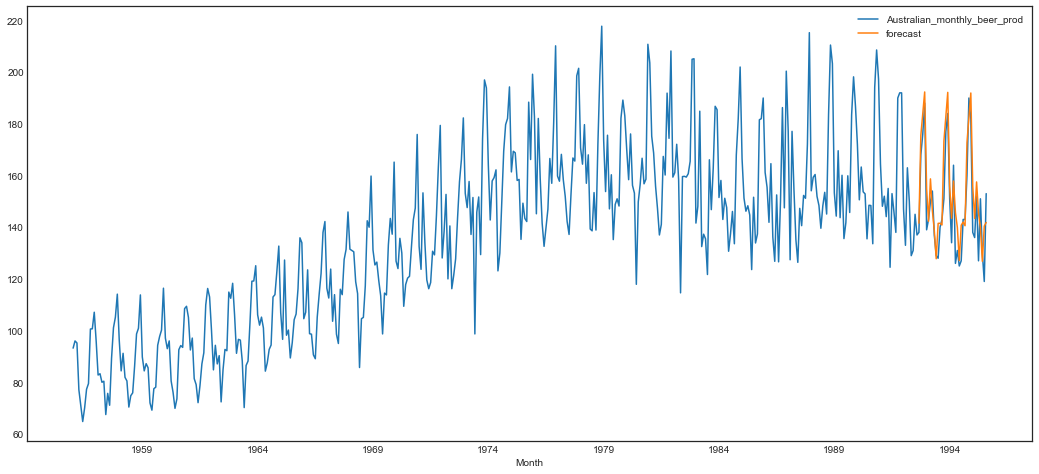

In [46]:
df['forecast'] = results.predict(start = 440, end= 476, dynamic= True)  
df[['Australian_monthly_beer_prod','forecast']].plot(figsize=(18,8))

## Forecasting

In [30]:
df.tail()

Australian_monthly_beer_prod  First_Diff  Second_Diff  \
Month                                                               
1995-04-01                         127.0       -25.0         -9.0   
1995-05-01                         151.0        24.0         -1.0   
1995-06-01                         130.0       -21.0          3.0   
1995-07-01                         119.0       -11.0        -32.0   
1995-08-01                         153.0        34.0         23.0   

            Seasonal_Diff    forecast  
Month                                  
1995-04-01            1.0  139.225242  
1995-05-01           20.0  134.546142  
1995-06-01            5.0  121.140694  
1995-07-01           -8.0  132.574062  
1995-08-01           10.0  136.833281

In [31]:
from pandas.tseries.offsets import DateOffset

In [32]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24) ]
future_dates

[Timestamp('1995-09-01 00:00:00'),
 Timestamp('1995-10-01 00:00:00'),
 Timestamp('1995-11-01 00:00:00'),
 Timestamp('1995-12-01 00:00:00'),
 Timestamp('1996-01-01 00:00:00'),
 Timestamp('1996-02-01 00:00:00'),
 Timestamp('1996-03-01 00:00:00'),
 Timestamp('1996-04-01 00:00:00'),
 Timestamp('1996-05-01 00:00:00'),
 Timestamp('1996-06-01 00:00:00'),
 Timestamp('1996-07-01 00:00:00'),
 Timestamp('1996-08-01 00:00:00'),
 Timestamp('1996-09-01 00:00:00'),
 Timestamp('1996-10-01 00:00:00'),
 Timestamp('1996-11-01 00:00:00'),
 Timestamp('1996-12-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1997-02-01 00:00:00'),
 Timestamp('1997-03-01 00:00:00'),
 Timestamp('1997-04-01 00:00:00'),
 Timestamp('1997-05-01 00:00:00'),
 Timestamp('1997-06-01 00:00:00'),
 Timestamp('1997-07-01 00:00:00')]

In [33]:
future_dates_df = pd.DataFrame(index=future_dates,columns=df.columns)
future_df = pd.concat([df,future_dates_df])

In [34]:
future_df.head()

Australian_monthly_beer_prod  First_Diff  Second_Diff  \
1956-01-01                          93.2         NaN          NaN   
1956-02-01                          96.0         2.8          NaN   
1956-03-01                          95.2        -0.8          2.0   
1956-04-01                          77.1       -18.1        -18.9   
1956-05-01                          70.9        -6.2        -24.3   

            Seasonal_Diff  forecast  
1956-01-01            NaN       NaN  
1956-02-01            NaN       NaN  
1956-03-01            NaN       NaN  
1956-04-01            NaN       NaN  
1956-05-01            NaN       NaN

In [35]:
future_df.tail()

Australian_monthly_beer_prod  First_Diff  Second_Diff  \
1997-03-01                           NaN         NaN          NaN   
1997-04-01                           NaN         NaN          NaN   
1997-05-01                           NaN         NaN          NaN   
1997-06-01                           NaN         NaN          NaN   
1997-07-01                           NaN         NaN          NaN   

            Seasonal_Diff  forecast  
1997-03-01            NaN       NaN  
1997-04-01            NaN       NaN  
1997-05-01            NaN       NaN  
1997-06-01            NaN       NaN  
1997-07-01            NaN       NaN

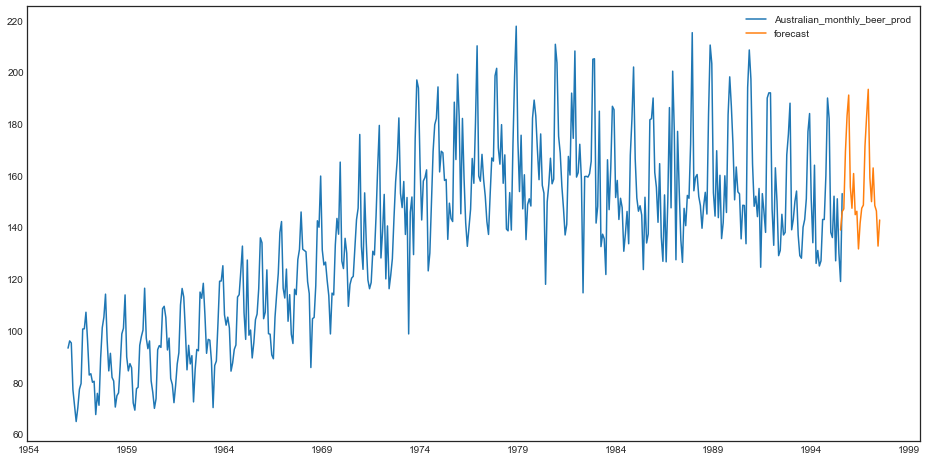

In [36]:
future_df['forecast'] = results.predict(start = 474, end = 499, dynamic= True)  
future_df[['Australian_monthly_beer_prod', 'forecast']].plot(figsize=(16, 8)); 

# Parking Lot

* notes from March 20th class on R:
    - seasonal deviation plot
    - if you don't see seasonality in a dataset that is supposed to have it, make sure it is not adjusted (see metadata)
    - Smoothing:
        - Holt with trend and no seasonality
        - Holt and ... 

In [37]:
%pwd

'/Users/gabrielestivalet/Nova IMS/S2/Métodos de Previsão/Python'